<a href="https://colab.research.google.com/github/ingenieradeltoro-bot/dashboard_portafolio.py/blob/main/EVIDENCIA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Descargando precios de Yahoo Finance (36 meses)...
2. Calculando Modelo de 5 Factores y Rendimientos Esperados...

Resultados Ordenados (Mayor a Menor Rendimiento Esperado):
  Ticker  Exp. Annual Return (%)  R-Squared
9     MA                 20.8181     0.5481
8      V                 15.9392     0.5518
0      F                 13.0594     0.5134
6    VNQ                 11.9522     0.8306
2     MU                 10.7365     0.5096
1   VTIP                  6.3744     0.4825
5   SHEL                  5.9044     0.3586
7   BABA                  2.9015     0.0832
4   FSLR                 -3.3751     0.3569
3     BE                -27.0234     0.4586

DECISIÓN DE PORTAFOLIO
Empresas MANTENIDAS (Top 5):
 ['MA', 'V', 'F', 'VNQ', 'MU']
Empresas ELIMINADAS (Bottom 5 - Menor rendimiento proyectado):
 ['VTIP', 'SHEL', 'BABA', 'FSLR', 'BE']
Empresa ganadora para simulación: MA

3. Ejecutando Monte Carlo para MA...


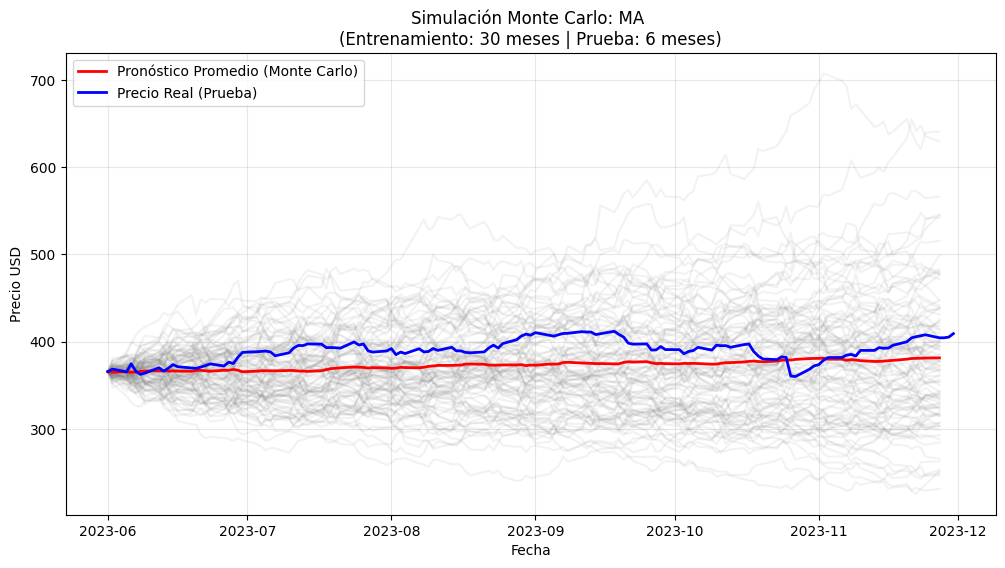

Descargando precios...

VaR (95%) Diario del Portafolio: 2.36%
Interpretación: Con un 95% de confianza, no perderás más del 2.36% de tu inversión en un solo día.


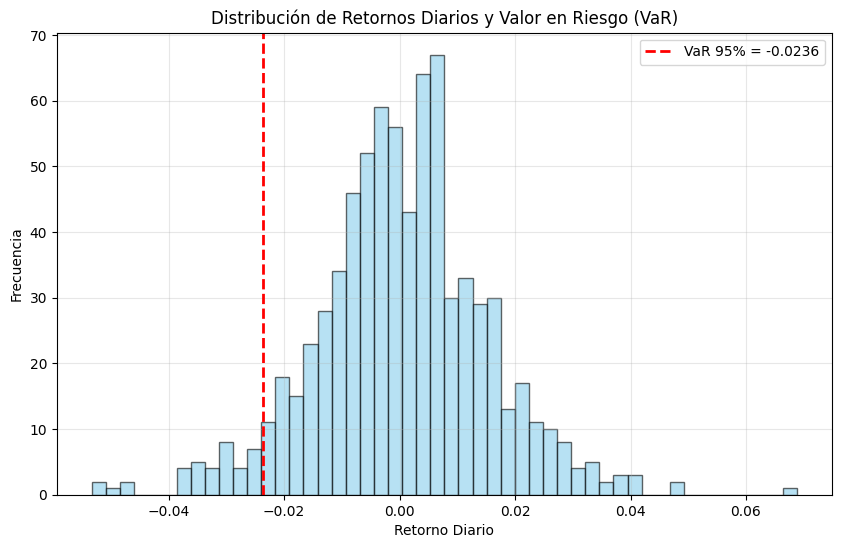


Pesos óptimos que maximizan el Sharpe Ratio:
MA    0.4528
V     0.0677
F     0.1217
VNQ   0.3539
MU    0.0038
Name: 7280, dtype: float64


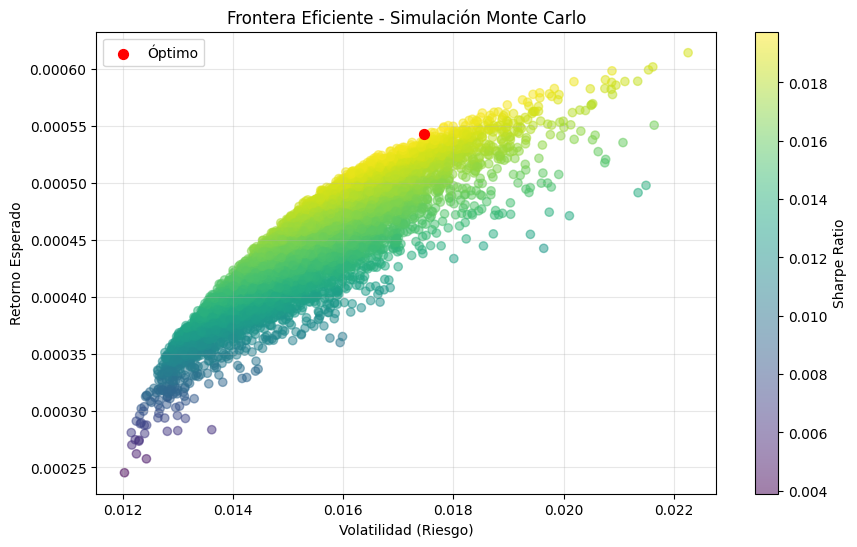

2025-12-07 05:43:53.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 05:43:53.005 No runtime found, using MemoryCacheStorageManager
2025-12-07 05:43:53.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 05:43:53.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 05:43:53.018 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 05:43:53.019 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 05:43:53.020 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 05:43:53.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 05:43:53.023 Thread 'MainThread':

DeltaGenerator()

In [10]:
# ==========================================
# CÓDIGO MAESTRO: PORTAFOLIO + 5 FACTORES + MONTE CARLO
# ==========================================

# 1. INSTALACIÓN DE LIBRERÍAS
!pip install yfinance statsmodels --quiet

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

# Configuración visual y supresión de alertas
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.4f}'.format

# ---------------------------------------------------------
# 2. PARÁMETROS DEL PROYECTO
# ---------------------------------------------------------
# Selección de 10 empresas diversificadas (Tech, Auto, Finanzas, Energía, Retail, Salud)
my_tickers = ['F', 'VTIP', 'MU', 'BE', 'FSLR', 'SHEL', 'VNQ', 'BABA', 'V', 'MA']

# Proxies para el Modelo de 5 Factores (usando ETFs para evitar bloqueo de servidor)
# 1. Mercado (SPY), 2. Tamaño (IWM), 3. Valor (VTV),
# 4. Calidad/Profitability (QUAL), 5. Momentum/Inversión (MTUM)
factor_tickers = ['SPY', 'IWM', 'VTV', 'QUAL', 'MTUM']

start_date = '2020-12-01'
end_date = '2023-12-01' # 36 Meses exactos
risk_free_rate_annual = 0.05 # Requisito: 5%

# ---------------------------------------------------------
# 3. DESCARGA Y PROCESAMIENTO DE DATOS
# ---------------------------------------------------------
print("1. Descargando precios de Yahoo Finance (36 meses)...")
all_data = yf.download(my_tickers + factor_tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Asegurar que usamos el precio ajustado de cierre
if 'Adj Close' in all_data.columns:
    prices = all_data['Adj Close']
else:
    prices = all_data['Close']

# Calcular retornos mensuales
monthly_prices = prices.resample('ME').last()
monthly_returns = monthly_prices.pct_change().dropna()

# Tasa libre de riesgo mensual
rf_monthly = (1 + risk_free_rate_annual)**(1/12) - 1

# ---------------------------------------------------------
# 4. CONSTRUCCIÓN DEL MODELO DE 5 FACTORES
# ---------------------------------------------------------
# Variables Independientes (X): Los 5 Factores - Tasa libre de riesgo
factors_df = pd.DataFrame()
factors_df['Mkt-RF'] = monthly_returns['SPY'] - rf_monthly
factors_df['Small_Cap'] = monthly_returns['IWM'] - rf_monthly
factors_df['Value'] = monthly_returns['VTV'] - rf_monthly
factors_df['Quality'] = monthly_returns['QUAL'] - rf_monthly
factors_df['Momentum'] = monthly_returns['MTUM'] - rf_monthly

X = sm.add_constant(factors_df) # Añadir constante (Alpha)

results_list = []

print("2. Calculando Modelo de 5 Factores y Rendimientos Esperados...")

for ticker in my_tickers:
    # Variable Dependiente (Y): Retorno del activo - Tasa libre de riesgo
    y = monthly_returns[ticker] - rf_monthly

    # Regresión Lineal Múltiple
    model = sm.OLS(y, X).fit()
    betas = model.params

    # Calcular Rendimiento Esperado usando la fórmula del modelo de factores
    # E(R) = Rf + Suma(Beta_i * Promedio_Factor_i)
    avg_premiums = factors_df.mean()
    expected_excess = (betas[factors_df.columns] * avg_premiums).sum()

    expected_monthly = rf_monthly + expected_excess
    expected_annual = (1 + expected_monthly)**12 - 1

    results_list.append({
        'Ticker': ticker,
        'Exp. Annual Return (%)': expected_annual * 100,
        'R-Squared': model.rsquared
    })

# Crear DataFrame y ordenar de MAYOR a MENOR
df_results = pd.DataFrame(results_list).sort_values(by='Exp. Annual Return (%)', ascending=False)

print("\nResultados Ordenados (Mayor a Menor Rendimiento Esperado):")
print(df_results[['Ticker', 'Exp. Annual Return (%)', 'R-Squared']])

# ---------------------------------------------------------
# 5. ESTRATEGIA DE PORTAFOLIO (SELECCIÓN Y ELIMINACIÓN)
# ---------------------------------------------------------
top_5 = df_results.head(5)
bottom_5 = df_results.tail(5)
best_stock = df_results.iloc[0]['Ticker']

print("\n" + "="*40)
print("DECISIÓN DE PORTAFOLIO")
print("="*40)
print(f"Empresas MANTENIDAS (Top 5):\n {top_5['Ticker'].tolist()}")
print(f"Empresas ELIMINADAS (Bottom 5 - Menor rendimiento proyectado):\n {bottom_5['Ticker'].tolist()}")
print(f"Empresa ganadora para simulación: {best_stock}")

# ---------------------------------------------------------
# 6. SIMULACIÓN MONTE CARLO (30m Train / 6m Test)
# ---------------------------------------------------------
print(f"\n3. Ejecutando Monte Carlo para {best_stock}...")

# Obtener precios diarios solo de la mejor empresa para mayor precisión
stock_daily = yf.download(best_stock, start=start_date, end=end_date, progress=False, auto_adjust=False)
adj_close_daily = stock_daily['Adj Close'] if 'Adj Close' in stock_daily.columns else stock_daily['Close']

# Si devuelve DataFrame, convertir a Series
if isinstance(adj_close_daily, pd.DataFrame):
    adj_close_daily = adj_close_daily.iloc[:, 0]

returns_daily = adj_close_daily.pct_change().dropna()

# DIVISIÓN: Primeros 30 meses (Entrenamiento) vs Últimos 6 meses (Prueba)
# 30 meses * 21 días hábiles aprox = 630 días (aproximación, usaremos corte por fecha)
cutoff_date = pd.to_datetime(start_date) + pd.DateOffset(months=30)
train = returns_daily[:cutoff_date]
test = returns_daily[cutoff_date:]

# Parámetros Simulación
mu = train.mean()
sigma = train.std()
S_0 = adj_close_daily.loc[train.index[-1]] # Último precio del entrenamiento
T_days = len(test)
N_SIM = 100

# Función GBM Vectorizada
def simulate_gbm(s_0, mu, sigma, n_sims, steps):
    # Generar choques aleatorios
    dt = 1
    dW = np.random.normal(0, 1, (n_sims, steps))
    # Drift
    drift = (mu - 0.5 * sigma**2) * dt
    # Difusión
    diffusion = sigma * np.sqrt(dt) * dW
    # Trayectorias
    daily_returns_sim = np.exp(drift + diffusion)
    # Acumular precio
    price_paths = np.zeros((n_sims, steps + 1))
    price_paths[:, 0] = s_0
    for t in range(1, steps + 1):
        price_paths[:, t] = price_paths[:, t-1] * daily_returns_sim[:, t-1]
    return price_paths

# Ejecutar
simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T_days)

# ---------------------------------------------------------
# 7. GRÁFICA DE RUTAS ESTIMADAS
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# Fechas para la gráfica (eje X)
sim_dates = pd.date_range(start=test.index[0], periods=T_days + 1, freq='B')

# Graficar simulaciones
plt.plot(sim_dates, simulations.T, color='gray', alpha=0.1)
# Graficar media de simulaciones
plt.plot(sim_dates, simulations.mean(axis=0), color='red', linewidth=2, label='Pronóstico Promedio (Monte Carlo)')
# Graficar datos reales (Test set)
plt.plot(test.index, adj_close_daily.loc[test.index], color='blue', linewidth=2, label='Precio Real (Prueba)')

plt.title(f'Simulación Monte Carlo: {best_stock} \n(Entrenamiento: 30 meses | Prueba: 6 meses)')
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf  # <--- FALTABA ESTA LÍNEA

# ----------------------------------------------------
# 1. PARÁMETROS
# ----------------------------------------------------
tickers_top5 = ['MA', 'V', 'F', 'VNQ', 'MU']
start_date = '2020-12-01'
end_date = '2023-12-01'

# ----------------------------------------------------
# 2. DESCARGA DE DATOS (CORREGIDA)
# ----------------------------------------------------
print("Descargando precios...")
# auto_adjust=False asegura que 'Adj Close' exista
data = yf.download(tickers_top5, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Selección segura de columna
if 'Adj Close' in data.columns:
    prices = data['Adj Close']
else:
    prices = data['Close']

# ----------------------------------------------------
# 3. CÁLCULO DE VaR
# ----------------------------------------------------
# Calcular retornos diarios
returns = prices.pct_change().dropna()

# Asignar pesos iguales (1/5 = 20% cada una)
weights = np.array([1/len(tickers_top5)] * len(tickers_top5))

# Retorno diario del portafolio (Producto punto de matrices)
portfolio_returns = returns.dot(weights)

# Cálculo de VaR con 95% de confianza (Histórico)
VaR_95 = np.percentile(portfolio_returns, 5)  # El valor en el percentil 5% más bajo
VaR_percent = -VaR_95 * 100  # Convertir a positivo para expresarlo como pérdida

print(f"\nVaR (95%) Diario del Portafolio: {VaR_percent:.2f}%")
print(f"Interpretación: Con un 95% de confianza, no perderás más del {VaR_percent:.2f}% de tu inversión en un solo día.")

# ----------------------------------------------------
# 4. GRÁFICA
# ----------------------------------------------------
plt.figure(figsize=(10,6))
plt.hist(portfolio_returns, bins=50, alpha=0.6, color='skyblue', edgecolor='black')
plt.axvline(x=VaR_95, color='red', linestyle='--', linewidth=2, label=f'VaR 95% = {VaR_95:.4f}')
plt.title("Distribución de Retornos Diarios y Valor en Riesgo (VaR)")
plt.xlabel("Retorno Diario")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()





n_assets = len(tickers_top5)
n_portfolios = 10000
rf = 0.05 / 252  # Tasa libre de riesgo diaria

mean_returns = returns.mean()
cov_matrix = returns.cov()

results = np.zeros((3, n_portfolios))  # retornos, volatilidad, Sharpe
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)

    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - rf) / vol

    results[0, i] = ret
    results[1, i] = vol
    results[2, i] = sharpe
    weights_record.append(weights)

# Convertir a DataFrame
results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe'])
weights_df = pd.DataFrame(weights_record, columns=tickers_top5)

# Encontrar portafolio óptimo
opt_idx = results_df['Sharpe'].idxmax()
opt_weights = weights_df.iloc[opt_idx]

print("\nPesos óptimos que maximizan el Sharpe Ratio:")
print(opt_weights)

# Gráfica Frontera Eficiente
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results_df.loc[opt_idx, 'Volatility'], results_df.loc[opt_idx, 'Return'], c='red', s=50, label='Óptimo')
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Retorno Esperado')
plt.title('Frontera Eficiente - Simulación Monte Carlo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()







!pip install streamlit yfinance matplotlib seaborn --quiet
import streamlit as st
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CONFIGURACIÓN DE LA PÁGINA ---
st.set_page_config(page_title="Dashboard de Inversión", layout="wide")

# --- 2. PARÁMETROS ---
tickers = ['MA', 'V', 'F', 'VNQ', 'MU']
vix = '^VIX'
start = '2020-12-01'
end = '2023-12-01'

# --- 3. DESCARGA DE DATOS (CORREGIDA) ---
# Usamos cache para que no descargue todo cada vez que tocas un botón
@st.cache_data
def load_data():
    # Descargar todo junto. auto_adjust=False asegura que exista 'Adj Close'
    df = yf.download(tickers + [vix], start=start, end=end, auto_adjust=False)

    # Manejo seguro de columnas (Adj Close vs Close)
    if 'Adj Close' in df.columns:
        data = df['Adj Close']
    else:
        data = df['Close']
    return data

try:
    data = load_data()
except Exception as e:
    st.error(f"Error al descargar datos: {e}")
    st.stop()

# --- 4. CÁLCULOS ---
# Separamos las acciones del VIX para calcular retornos del portafolio
stock_data = data[tickers]
returns = stock_data.pct_change().dropna()

# Retorno acumulado promedio (equi-ponderado)
portfolio_ret = returns.mean(axis=1).cumsum()

# --- 5. DASHBOARD INTERFAZ ---
st.title("📊 Dashboard Interactivo del Portafolio")
st.markdown("Análisis de acciones financieras, tecnológicas y bienes raíces.")

# Layout de columnas para métricas
col1, col2 = st.columns(2)

with col1:
    st.subheader("🔁 Retorno acumulado del portafolio")
    st.line_chart(portfolio_ret)

with col2:
    st.subheader("📋 Precios de cierre más recientes")
    # Mostramos los últimos precios disponibles
    latest_prices = stock_data.iloc[-1]
    st.dataframe(latest_prices.to_frame("Precio USD").style.format("{:.2f}"))

st.divider()

# Sección de Correlación
st.subheader("📈 Correlación entre Acción vs Volatilidad (VIX)")

# Selector de acción
action = st.selectbox("Selecciona una acción para analizar:", tickers)

# Cálculo de correlación específico
col_action, col_graph = st.columns([1, 3])

with col_action:
    # Combinamos la acción seleccionada y el VIX
    df_corr = data[[action, vix]].pct_change().dropna()
    correlation_value = df_corr.corr().iloc[0, 1]

    st.metric(label=f"Correlación {action} vs VIX", value=f"{correlation_value:.2f}")

    if correlation_value < -0.5:
        st.info("💡 Correlación negativa fuerte: La acción tiende a subir cuando el miedo (VIX) baja.")
    elif correlation_value > 0.5:
        st.warning("⚠️ Correlación positiva: La acción se mueve igual que la volatilidad.")

with col_graph:
    # Gráfico de dispersión (Scatter Plot)
    fig_corr, ax = plt.subplots(figsize=(8, 4))
    sns.scatterplot(x=data[vix], y=data[action], ax=ax, color='blue', alpha=0.6)
    ax.set_title(f'Relación: {action} vs VIX')
    ax.set_xlabel('Índice de Volatilidad (^VIX)')
    ax.set_ylabel(f'Precio de {action}')
    ax.grid(True, alpha=0.3)
    st.pyplot(fig_corr)

st.divider()

# Sección de Retornos Diarios
st.subheader("📉 Volatilidad de Retornos Diarios")
fig_ret, ax = plt.subplots(figsize=(12, 5))
returns.plot(ax=ax, alpha=0.7)
plt.title("Comparación de Retornos Diarios")
plt.ylabel("Retorno %")
plt.grid(True, alpha=0.3)
st.pyplot(fig_ret)
